In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
import os
import rasterio
from rasterio.plot import show as Show
from rasterio import mask as mask
import pylab as plt
data = os.getenv('data')
from rasterstats import point_query
import pycountry
import shapely
from shapely import wkt
import warnings
warnings.filterwarnings('ignore')


### Landslide analysis of POIs for EU countries

In [3]:
landslide_pth = data+'/energy/LS_RF_Mean_1980-2018.tif'  # ARUP landslide layer downloaded from DDH (rainfall trigge)

#### 1. Get subnational boundaries

In [7]:
pycountry.countries.search_fuzzy('Bosnia')

[Country(alpha_2='BA', alpha_3='BIH', name='Bosnia and Herzegovina', numeric='070', official_name='Republic of Bosnia and Herzegovina')]

In [8]:
countries = ['Austria','Croatia','Greece','Slovakia','Slovenia','Montenegro','Bosnia and Herzegovina']
alpha3s = []
for country in countries:
    countries_db = pycountry.countries.get(name=country)
    alpha3s.append(countries_db.alpha_3)
alpha3s

['AUT', 'HRV', 'GRC', 'SVK', 'SVN', 'MNE', 'BIH']

In [10]:
def get_boundaries(alpha3,verbose=True):
    r = requests.get("https://www.geoboundaries.org/gbRequest.html?ISO={}&ADM=ADM1".format(alpha3))
    dlPath = r.json()[0]['gjDownloadURL']
    geoBoundary = requests.get(dlPath).json()
    gdf = gpd.GeoDataFrame.from_features(geoBoundary['features'])[['geometry','shapeName']]
    if verbose:
        print('{}: retrieved {} features'.format(alpha3, len(gdf)))
    return(gdf)

In [11]:
boundaries_Austria = get_boundaries('AUT')
boundaries_Croatia = get_boundaries('HRV')
boundaries_Greece = get_boundaries('GRC')
boundaries_Slovakia = get_boundaries('SVK')
boundaries_Slovenia = get_boundaries('SVN')
boundaries_Montenegro = get_boundaries('MNE')
boundaries_Bosnia = get_boundaries('BIH')

BIH: retrieved 3 features


#### 2. Point query Montenegro

In [13]:
def schools_pth(country):
    return(data + '/osm/{}/{}_school.shp'.format(country,country))

In [42]:
schools_pth('montenegro')

'/home/nicholasjones/Data/osm/montenegro/montenegro_school.shp'

In [73]:
montenegro_schools = gpd.read_file(schools_pth('montenegro'))

In [74]:
montenegro_schools['landslide_prob'] = point_query(montenegro_schools, landslide_pth)
montenegro_schools.landslide_prob = montenegro_schools.landslide_prob.fillna(0) * 100

<AxesSubplot:>

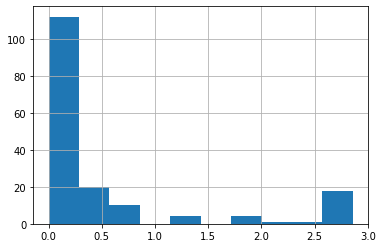

In [75]:
montenegro_schools['landslide_prob'].hist()

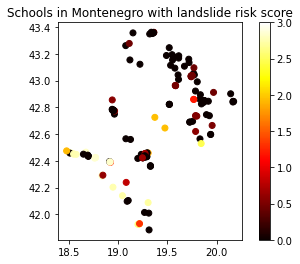

In [77]:
f,ax = plt.subplots()
montenegro_schools.plot(ax = ax,column = 'landslide_prob',legend=True,cmap='hot',vmax=3,figsize=[10,10])
#boundaries[boundaries.region == "Valle d'Aosta"].plot(facecolor='b',alpha=0.3,ax=ax)
plt.title("Schools in Montenegro with landslide risk score");

In [79]:
montenegro_schools = gpd.sjoin(montenegro_schools,boundaries_Montenegro)    # spatial join POIs with boundaries
montenegro_schools.drop(columns=['index_right'],inplace=True)
montenegro_schools


,name,amenity,geometry,landslide_prob,shapeName
0,"JU Osnovna ?kola ""Bo?idar Vukovi? Podgori?anin""",school,POINT (19.29199 42.43151),0.000000,Podgorica Municipality
1,"JU Srednja ekonomska ?kola ""Mirko Ve?ovi?""",school,POINT (19.25930 42.43300),0.000000,Podgorica Municipality
2,"JU Srednja stru?na ?kola ""Sergije Stani?""",school,POINT (19.25768 42.43161),0.658943,Podgorica Municipality
3,JU Srednja medicinska ?kola,school,POINT (19.24955 42.43642),0.000000,Podgorica Municipality
4,"JU Srednja gra?evinsko-geodetska ?kola ""In?. M...",school,POINT (19.25161 42.44495),0.000000,Podgorica Municipality
...,...,...,...,...,...
113,Gimnazija 30. septembar,school,POINT (20.17341 42.84373),0.000000,Ro?aje Municipality
114,O? Mustafa Pe?anin,school,POINT (20.16737 42.84488),0.000000,Ro?aje Municipality
115,O? 25. Maj,school,POINT (20.16588 42.83949),0.000000,Ro?aje Municipality
131,None,school,POINT (19.83132 42.56438),0.000000,Gusinje Municipality


In [80]:
# mean landslide risk at hospitals in each region (other summary stats also possible)
mean_landslide_prob = montenegro_schools.groupby('shapeName').mean().sort_values(by='landslide_prob',ascending=False)
mean_landslide_prob.head()   

,landslide_prob
shapeName,
Kotor Municipality,2.859099
Budva Municipality,2.351774
Herceg Novi Municipality,2.062735
Cetinje Municipality,1.743944
Bar Municipality,1.251984


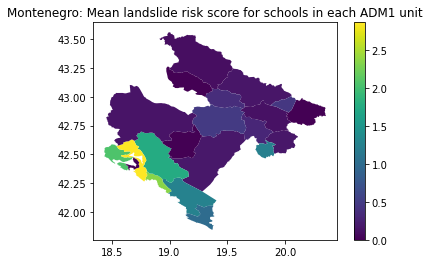

In [84]:
# join back with boundaries and visualize mean values
boundaries_Montenegro = boundaries_Montenegro.merge(mean_landslide_prob,left_on='shapeName',right_on = mean_landslide_prob.index)
boundaries_Montenegro.rename(columns = {'landslide_prob':'mean_landslide_prob'},inplace=True)
boundaries_Montenegro.plot(column = 'mean_landslide_prob',legend=True)
plt.title('Montenegro: Mean landslide risk score for schools in each ADM1 unit');

#### 3. Point query function

In [ ]:
def query_landslide(pois_gdf):
    

In [14]:
bosnia_schools = gpd.read_file(schools_pth('bosnia'))

In [ ]:
montenegro_schools['landslide_prob'] = point_query(montenegro_schools, landslide_pth)
montenegro_schools.landslide_prob = montenegro_schools.landslide_prob.fillna(0) * 100